In [ ]:

#Basic Libraries
import numpy as np
import pandas as pd

#Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

#Text Handling Libraries
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from sklearn.metrics import jaccard_score
from scipy.sparse import csr_matrix



#clustering
from sklearn.cluster import KMeans


In [ ]:
from google.colab import drive



# Mount Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


<a id='section-3'></a>
<p style="background-color:#373435;color:#fff;font-family:newtimeroman;font-size:200%;text-align:center;border-radius:10px 10px; padding:10px;">Data Loading and Cleaning</p>

<p style="text-align:center;">
<a href="#section-0" style="background-color:#373333;color:#f1f1f1;font-family:newtimeroman;text-align:center;border-radius:10px 10px; padding:10px;">Back To Top</a>
</p>

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/BigBasket Products.csv',index_col='index')

In [ ]:
df.head()

,product,category,sub_category,brand,sale_price,market_price,type,rating,description
index,,,,,,,,,
1,Garlic Oil - Vegetarian Capsule 500 mg,Beauty & Hygiene,Hair Care,Sri Sri Ayurveda,220.0,220.0,Hair Oil & Serum,4.1,This Product contains Garlic Oil that is known...
2,Water Bottle - Orange,"Kitchen, Garden & Pets",Storage & Accessories,Mastercook,180.0,180.0,Water & Fridge Bottles,2.3,"Each product is microwave safe (without lid), ..."
3,"Brass Angle Deep - Plain, No.2",Cleaning & Household,Pooja Needs,Trm,119.0,250.0,Lamp & Lamp Oil,3.4,"A perfect gift for all occasions, be it your m..."
4,Cereal Flip Lid Container/Storage Jar - Assort...,Cleaning & Household,Bins & Bathroom Ware,Nakoda,149.0,176.0,"Laundry, Storage Baskets",3.7,Multipurpose container with an attractive desi...
5,Creme Soft Soap - For Hands & Body,Beauty & Hygiene,Bath & Hand Wash,Nivea,162.0,162.0,Bathing Bars & Soaps,4.4,Nivea Creme Soft Soap gives your skin the best...


In [ ]:
df['description'].head()

index
1    This Product contains Garlic Oil that is known...
2    Each product is microwave safe (without lid), ...
3    A perfect gift for all occasions, be it your m...
4    Multipurpose container with an attractive desi...
5    Nivea Creme Soft Soap gives your skin the best...
Name: description, dtype: object

In [ ]:
df.isnull().sum()

product            1
category           0
sub_category       0
brand              1
sale_price         0
market_price       0
type               0
rating          8626
description      115
dtype: int64

In [ ]:
print('Percentage Null Data In Each Column')
print('-'*30)
for col in df.columns:
    null_count = df[col].isnull().sum()
    total_count = df.shape[0]
    print("{} : {:.2f}".format(col,null_count/total_count * 100))

Percentage Null Data In Each Column
------------------------------
product : 0.00
category : 0.00
sub_category : 0.00
brand : 0.00
sale_price : 0.00
market_price : 0.00
type : 0.00
rating : 31.30
description : 0.42


In [ ]:
print('Total Null Data')
null_count = df.isnull().sum().sum()
total_count = np.product(df.shape)
print("{:.2f}".format(null_count/total_count * 100))

Total Null Data
3.53


<p style="color:#373435; font-size:16px;font-weight:400;">So overall 3% data is missing but 31% of ratings are missing.
Since we are going to create a recommender system, let's drop the null values as their will still be over 69% data for recommendation purposes which is enough for us.</p>

In [ ]:
df = df.dropna()

In [ ]:
df.isnull().sum()

product         0
category        0
sub_category    0
brand           0
sale_price      0
market_price    0
type            0
rating          0
description     0
dtype: int64

In [ ]:
df.shape

(18840, 9)

In [ ]:
# df.to_csv('data_cleaned.csv')

<p style="color:#373435; font-size:16px;font-weight:400;">So even after dropping null data, 18000+ products are available for recommendation.<br>
Let's recommend now!!</p>

<a id='section-4'></a>
<p style="background-color:#373435;color:#fff;font-family:newtimeroman;font-size:200%;text-align:center;border-radius:10px 10px; padding:10px;">Exploratory Data Analysis</p>

<p style="text-align:center;">
<a href="#section-0" style="background-color:#373333;color:#f1f1f1;font-family:newtimeroman;text-align:center;border-radius:10px 10px; padding:10px;">Back To Top</a>
</p>

In [ ]:
df.head()

,product,category,sub_category,brand,sale_price,market_price,type,rating,description
index,,,,,,,,,
1,Garlic Oil - Vegetarian Capsule 500 mg,Beauty & Hygiene,Hair Care,Sri Sri Ayurveda,220.0,220.0,Hair Oil & Serum,4.1,This Product contains Garlic Oil that is known...
2,Water Bottle - Orange,"Kitchen, Garden & Pets",Storage & Accessories,Mastercook,180.0,180.0,Water & Fridge Bottles,2.3,"Each product is microwave safe (without lid), ..."
3,"Brass Angle Deep - Plain, No.2",Cleaning & Household,Pooja Needs,Trm,119.0,250.0,Lamp & Lamp Oil,3.4,"A perfect gift for all occasions, be it your m..."
4,Cereal Flip Lid Container/Storage Jar - Assort...,Cleaning & Household,Bins & Bathroom Ware,Nakoda,149.0,176.0,"Laundry, Storage Baskets",3.7,Multipurpose container with an attractive desi...
5,Creme Soft Soap - For Hands & Body,Beauty & Hygiene,Bath & Hand Wash,Nivea,162.0,162.0,Bathing Bars & Soaps,4.4,Nivea Creme Soft Soap gives your skin the best...


In [ ]:
counts = df['category'].value_counts()

counts_df = pd.DataFrame({'Category':counts.index,'Counts':counts.values})

In [ ]:
px.bar(data_frame=counts_df,
 x='Category',
 y='Counts',
 color='Counts',
 color_continuous_scale='blues',
 text_auto=True,
 title=f'Count of Items in Each Category')


In [ ]:
counts = df['sub_category'].value_counts()

counts_df_1 = pd.DataFrame({'Category':counts.index,'Counts':counts.values})[:10]

In [ ]:
px.bar(data_frame=counts_df_1,
 x='Category',
 y='Counts',
 color='Counts',
 color_continuous_scale='blues',
 text_auto=True,
 title=f'Top 10 Bought Sub_Categories')


In [ ]:
counts = df['brand'].value_counts()

counts_df_brand = pd.DataFrame({'Brand Name':counts.index,'Counts':counts.values})[:10]

In [ ]:
px.bar(data_frame=counts_df_brand,
 x='Brand Name',
 y='Counts',
 color='Counts',
 color_continuous_scale='blues',
 text_auto=True,
 title=f'Top 10 Brand Items based on Item Counts')

In [ ]:
counts = df['type'].value_counts()

counts_df_type = pd.DataFrame({'Type':counts.index,'Counts':counts.values})[:10]

In [ ]:
px.bar(data_frame=counts_df_type,
 x='Type',
 y='Counts',
 color='Counts',
 color_continuous_scale='blues',
 text_auto=True,
 title=f'Top 10 Types of Products based on Item Counts')

<a id='section-5'></a>
<p style="background-color:#373435;color:#fff;font-family:newtimeroman;font-size:200%;text-align:center;border-radius:10px 10px; padding:10px;">Demographic Filter Recommendor</p>

<p style="text-align:center;">
<a href="#section-0" style="background-color:#373333;color:#f1f1f1;font-family:newtimeroman;text-align:center;border-radius:10px 10px; padding:10px;">Back To Top</a>
</p>

<p style="color:#373435; font-size:16px;font-weight:400;">Demographic Filtering is like recommeding items based on a feature. Like the top 10 rated items or the top 10 items in a particular category.</p>

In [ ]:
def sort_recommendor(col='rating',sort_type = False):
    """
    A recommendor based on sorting products on the column passed.
    Arguments to be passed:

    col: The Feature to be used for recommendation.
    sort_type: True for Ascending Order
    """
    rated_recommend = df.copy()
    if rated_recommend[col].dtype == 'O':
        col='rating'
    rated_recommend = rated_recommend.sort_values(by=col,ascending = sort_type)
    return rated_recommend[['product','brand','sale_price','rating']].head(10)

In [ ]:
help(sort_recommendor)

Help on function sort_recommendor in module __main__:

sort_recommendor(col='rating', sort_type=False)
    A recommendor based on sorting products on the column passed.
    Arguments to be passed:
    
    col: The Feature to be used for recommendation.
    sort_type: True for Ascending Order



In [ ]:
sort_recommendor(col='sale_price',sort_type=True)

,product,brand,sale_price,rating
index,,,,
21313,Serum,Livon,3.0,2.5
18291,Sugar Coated Chocolate,Cadbury Gems,5.0,4.2
21229,Dish Shine Bar,Exo,5.0,4.2
14539,Cadbury Perk - Chocolate Bar,Cadbury,5.0,4.2
19539,Layer Cake - Chocolate,Winkies,5.0,4.2
2979,Sugar Free Chewing Gum - Mixed Fruit,Orbit,5.0,4.2
15927,Dreams Cup Cake - Choco,Elite,5.0,3.9
6015,Good Day Butter Cookies,Britannia,5.0,4.1
27414,Layer Cake - Orange,Winkies,5.0,4.1


<p style="color:#373435; font-size:16px;font-weight:400;">Notice that our top product has rating of 2.5 which is quite bad so let's filter down by setting a threshold rating.</p>

In [ ]:
C= df['rating'].mean()
C

3.9430626326963902

<p style="color:#373435; font-size:16px;font-weight:400;">So the average rating of products is 3.94
Let's use 3.5 as the threshold.</p>

In [ ]:
def sort_recommendor(col='rating',sort_type = False):
    """
    A recommendor based on sorting products on the column passed.
    Arguments to be passed:

    col: The Feature to be used for recommendation.
    sort_type: True for Ascending Order
    """
    rated_recommend = df.copy().loc[df['rating'] >= 3.5]
    if rated_recommend[col].dtype == 'O':
        col='rating'
    rated_recommend = rated_recommend.sort_values(by=col,ascending = sort_type)
    return rated_recommend[['product','brand','sale_price','rating']].head(10)

In [ ]:
sort_recommendor(col='sale_price',sort_type=True)

,product,brand,sale_price,rating
index,,,,
2762,Orbit Sugar-Free Chewing Gum - Lemon & Lime,Wrigleys,5.0,4.2
3446,Marie Light Biscuits - Active,Sunfeast,5.0,4.5
14604,50-50 Timepass Biscuits,Britannia,5.0,3.9
17641,Hand Wash - Moisture Shield,Savlon,5.0,4.4
27491,50-50 Timepass Salted Biscuits,Britannia,5.0,4.2
26585,Polo - The Mint With The Hole,Nestle,5.0,4.4
2979,Sugar Free Chewing Gum - Mixed Fruit,Orbit,5.0,4.2
19539,Layer Cake - Chocolate,Winkies,5.0,4.2
19203,Bounce Biscuits - Choco Creme,Sunfeast,5.0,4.2


<p style="color:#373435; font-size:16px;font-weight:400;">Notice that the 2.5 rated product is not recommended now!!
This was our first recommendor.
<br>
Quite easy yet effective and used a lot !!</p>

<a id='section-6'></a>
<p style="background-color:#373435;color:#fff;font-family:newtimeroman;font-size:200%;text-align:center;border-radius:10px 10px; padding:10px;">Content Based Recommendor</p>

<p style="text-align:center;">
<a href="#section-0" style="background-color:#373333;color:#f1f1f1;font-family:newtimeroman;text-align:center;border-radius:10px 10px; padding:10px;">Back To Top</a>
</p>

In [ ]:
df.head()

,product,category,sub_category,brand,sale_price,market_price,type,rating,description
index,,,,,,,,,
1,Garlic Oil - Vegetarian Capsule 500 mg,Beauty & Hygiene,Hair Care,Sri Sri Ayurveda,220.0,220.0,Hair Oil & Serum,4.1,This Product contains Garlic Oil that is known...
2,Water Bottle - Orange,"Kitchen, Garden & Pets",Storage & Accessories,Mastercook,180.0,180.0,Water & Fridge Bottles,2.3,"Each product is microwave safe (without lid), ..."
3,"Brass Angle Deep - Plain, No.2",Cleaning & Household,Pooja Needs,Trm,119.0,250.0,Lamp & Lamp Oil,3.4,"A perfect gift for all occasions, be it your m..."
4,Cereal Flip Lid Container/Storage Jar - Assort...,Cleaning & Household,Bins & Bathroom Ware,Nakoda,149.0,176.0,"Laundry, Storage Baskets",3.7,Multipurpose container with an attractive desi...
5,Creme Soft Soap - For Hands & Body,Beauty & Hygiene,Bath & Hand Wash,Nivea,162.0,162.0,Bathing Bars & Soaps,4.4,Nivea Creme Soft Soap gives your skin the best...


<p style="color:#373435; font-size:16px;font-weight:400;">Let's try using other features such as Category, Sub Category, Brand, Type and Description for much better Recommendation.<br>
We will be using NLP here to extract useful info from the features especially Description so let's understand TF-IDF before using it.</p>

In [ ]:
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['description'])
print(tfidf_matrix)
tfidf_matrix.shape

  (0, 2973)	0.16673068073191316
  (0, 2779)	0.15649397195519346
  (0, 10189)	0.1654037720447062
  (0, 22495)	0.18020420454640665
  (0, 21571)	0.1719818837111654
  (0, 21225)	0.16381407818082885
  (0, 2544)	0.15520956605521033
  (0, 10433)	0.20714520105261564
  (0, 3436)	0.23817439346382313
  (0, 3761)	0.31309396885142093
  (0, 20394)	0.23046774054758032
  (0, 12091)	0.21302120258892618
  (0, 4332)	0.19271150578387639
  (0, 12628)	0.19262404683084158
  (0, 6358)	0.21174895739145674
  (0, 16470)	0.4933602005439521
  (0, 9921)	0.14642088477391424
  (0, 11660)	0.1640312228588762
  (0, 14612)	0.12885563434058553
  (0, 8880)	0.2149314057462619
  (0, 5107)	0.13644948630377232
  (0, 16400)	0.13773736732325734
  (1, 7864)	0.24289871184009051
  (1, 9241)	0.12235187755082079
  (1, 12372)	0.14373145272228377
  :	:
  (18839, 12418)	0.15306735073618336
  (18839, 5915)	0.16295334976854509
  (18839, 6761)	0.17165763165932174
  (18839, 21974)	0.16230782037228775
  (18839, 9352)	0.15349153889169964
  (1

(18840, 23342)

<p style="color:#373435; font-size:16px;font-weight:400;">
Now to compute the similarity score, let's use Linear_Kernel.
    <br>
    Linear Kernel which Calculates the Dot Product of the tfidf_matrix and returns an aggreate value depicting the Similarity score.
</p>

Cosine similarity is the measure of similarity between two vectors, by computing the cosine of the angle between two vectors projected into multidimensional space. It can be applied to items available on a dataset to compute similarity to one another via keywords or other metrics. Similarity between two vectors (A and B) is calculated by taking the dot product of the two vectors and dividing it by the magnitude value as shown in the equation below. We can simply say that the CS score of two vectors increases as the angle between them decreases.


In [ ]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
cosine_sim

array([[1.        , 0.01632718, 0.00999603, ..., 0.01056047, 0.01133156,
        0.        ],
       [0.01632718, 1.        , 0.00719713, ..., 0.        , 0.        ,
        0.        ],
       [0.00999603, 0.00719713, 1.        , ..., 0.00635776, 0.        ,
        0.        ],
       ...,
       [0.01056047, 0.        , 0.00635776, ..., 1.        , 0.        ,
        0.        ],
       [0.01133156, 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

<p style="color:#373435; font-size:16px;font-weight:400;">
So we will be recommending items based on similarity score.<br>
But our problem is that we will be getting back the similarity scores so we will be sorting the scores.<br>
Now we need a reverse-map to get the title and that is what <b>indices</b> is for.
</p>

In [ ]:
indices = pd.Series(df.index, index=df['product']).drop_duplicates()

def get_recommendations_1(title, cosine_sim=cosine_sim):

    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]
    movie_indices = [i[0] for i in sim_scores]
    return df['product'].iloc[movie_indices]

In [ ]:
get_recommendations_1('Water Bottle - Orange')

index
1677         Brass Nanda Stand Goblets - No.1
2162         Brass Kachua Stand Deepam - No.1
2756     Brass Angle Deep Stand - Plain, No.2
5400       Brass Lakshmi Deepam - Plain, No.2
6520                Brass Kuber Deepam - No.1
10504               Brass Kuber Deepam - No.2
11226    Brass Angle Deep Stand - Plain, No.3
11504    Brass Angle Deep Stand - Plain, No.1
12699        Brass Kachua Stand Deepam - No.2
18572               Brass Kuber Deepam - No.3
Name: product, dtype: object

In [ ]:
get_recommendations_1('Cadbury Perk - Chocolate Bar')

index
27049                        Pickle - Mixed
6601                  Pickle - Kaduku Mango
17934                Pickle - Mix Vegetable
27105                        Pickle - Prawn
3962                  Pickle - Tender Mango
16875             Olive Oil - Carrot Pickle
3444                     Pickle - Cut Mango
17237      Andhra Special Red Chilli Pickle
27234    Pickle - Lime (South Indian Style)
4955                    Pickle - Gooseberry
Name: product, dtype: object

<p style="color:#373435; font-size:16px;font-weight:400;">
Our search was chocolate yet we got Cashews and Nuts recommended. <br>
We need to optimize this based on category, sub_category and brand.
</p>

In [ ]:
df2 = df.copy()

In [ ]:
df2.head()

,product,category,sub_category,brand,sale_price,market_price,type,rating,description
index,,,,,,,,,
1,Garlic Oil - Vegetarian Capsule 500 mg,Beauty & Hygiene,Hair Care,Sri Sri Ayurveda,220.0,220.0,Hair Oil & Serum,4.1,This Product contains Garlic Oil that is known...
2,Water Bottle - Orange,"Kitchen, Garden & Pets",Storage & Accessories,Mastercook,180.0,180.0,Water & Fridge Bottles,2.3,"Each product is microwave safe (without lid), ..."
3,"Brass Angle Deep - Plain, No.2",Cleaning & Household,Pooja Needs,Trm,119.0,250.0,Lamp & Lamp Oil,3.4,"A perfect gift for all occasions, be it your m..."
4,Cereal Flip Lid Container/Storage Jar - Assort...,Cleaning & Household,Bins & Bathroom Ware,Nakoda,149.0,176.0,"Laundry, Storage Baskets",3.7,Multipurpose container with an attractive desi...
5,Creme Soft Soap - For Hands & Body,Beauty & Hygiene,Bath & Hand Wash,Nivea,162.0,162.0,Bathing Bars & Soaps,4.4,Nivea Creme Soft Soap gives your skin the best...


In [ ]:
df2.shape

(18840, 9)

<p style="color:#373435; font-size:16px;font-weight:400;">
Notice that a product can be in multiple catergories and sub_categories and they are separated with a &.<br>
Let's split them into a list for futher processes.
</p>

In [ ]:
rmv_spc = lambda a:a.strip()
get_list = lambda a:list(map(rmv_spc,re.split('& |, |\*|\n', a)))

In [ ]:
get_list('A & B, C')

['A', 'B', 'C']

In [ ]:
for col in ['category', 'sub_category', 'type']:
    df2[col] = df2[col].apply(get_list)

In [ ]:
df2.head()

,product,category,sub_category,brand,sale_price,market_price,type,rating,description
index,,,,,,,,,
1,Garlic Oil - Vegetarian Capsule 500 mg,"[Beauty, Hygiene]",[Hair Care],Sri Sri Ayurveda,220.0,220.0,"[Hair Oil, Serum]",4.1,This Product contains Garlic Oil that is known...
2,Water Bottle - Orange,"[Kitchen, Garden, Pets]","[Storage, Accessories]",Mastercook,180.0,180.0,"[Water, Fridge Bottles]",2.3,"Each product is microwave safe (without lid), ..."
3,"Brass Angle Deep - Plain, No.2","[Cleaning, Household]",[Pooja Needs],Trm,119.0,250.0,"[Lamp, Lamp Oil]",3.4,"A perfect gift for all occasions, be it your m..."
4,Cereal Flip Lid Container/Storage Jar - Assort...,"[Cleaning, Household]","[Bins, Bathroom Ware]",Nakoda,149.0,176.0,"[Laundry, Storage Baskets]",3.7,Multipurpose container with an attractive desi...
5,Creme Soft Soap - For Hands & Body,"[Beauty, Hygiene]","[Bath, Hand Wash]",Nivea,162.0,162.0,"[Bathing Bars, Soaps]",4.4,Nivea Creme Soft Soap gives your skin the best...


<p style="color:#373435; font-size:16px;font-weight:400;">
To avoid duplicacy, we will be converting everything to lowercase and also removing spaces between words. <br>
    This will ensure that our recommendor doesn't consider <b>Chocolate</b> of <b>Cholocate IceCream</b> and <b>Chocolate Bar</b> as the same.
</p>

In [ ]:
def cleaner(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''

In [ ]:
for col in ['category', 'sub_category', 'type','brand']:
    df2[col] = df2[col].apply(cleaner)

In [ ]:
df2.head()

,product,category,sub_category,brand,sale_price,market_price,type,rating,description
index,,,,,,,,,
1,Garlic Oil - Vegetarian Capsule 500 mg,"[beauty, hygiene]",[haircare],srisriayurveda,220.0,220.0,"[hairoil, serum]",4.1,This Product contains Garlic Oil that is known...
2,Water Bottle - Orange,"[kitchen, garden, pets]","[storage, accessories]",mastercook,180.0,180.0,"[water, fridgebottles]",2.3,"Each product is microwave safe (without lid), ..."
3,"Brass Angle Deep - Plain, No.2","[cleaning, household]",[poojaneeds],trm,119.0,250.0,"[lamp, lampoil]",3.4,"A perfect gift for all occasions, be it your m..."
4,Cereal Flip Lid Container/Storage Jar - Assort...,"[cleaning, household]","[bins, bathroomware]",nakoda,149.0,176.0,"[laundry, storagebaskets]",3.7,Multipurpose container with an attractive desi...
5,Creme Soft Soap - For Hands & Body,"[beauty, hygiene]","[bath, handwash]",nivea,162.0,162.0,"[bathingbars, soaps]",4.4,Nivea Creme Soft Soap gives your skin the best...


<p style="color:#373435; font-size:16px;font-weight:400;">
We will now be joining the values of category, sub_category, type and brand
</p>

In [ ]:
def couple(x):
    return ' '.join(x['category']) + ' ' + ' '.join(x['sub_category']) + ' '+x['brand']+' ' +' '.join( x['type'])
df2['soup'] = df2.apply(couple, axis=1)

In [ ]:
df2['soup'].head()



index
1    beauty hygiene haircare srisriayurveda hairoil...
2    kitchen garden pets storage accessories master...
3       cleaning household poojaneeds trm lamp lampoil
4    cleaning household bins bathroomware nakoda la...
5    beauty hygiene bath handwash nivea bathingbars...
Name: soup, dtype: object

**bold text**

Bhai edit korio na eta te onno ekta file e edit korio eta r kaaj baki ase** **bold text**

In [ ]:
import nltk
nltk.download('wordnet')

nltk.download('stopwords')

import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

def clean_text(text):

    # Tokenize the text.
    tokens = re.split(r"\W+", text)

    # Lowercase the tokens.
    tokens = [token.lower() for token in tokens]

    # Remove stopwords.
    stopwords1 = set(stopwords.words("english"))
    tokens = [token for token in tokens if token not in stopwords1]

    # Lemmatize the tokens.
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Remove duplicates.
    tokens = list(set(tokens))

    return tokens


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
df['product_des'] = df['description'].apply(clean_text)
df['product_des'].head()

index
1    [, blog, digestion, immunity, level, proper, h...
2    [, factor, attractive, microwave, wide, look, ...
3    [, foot, law, sister, beautiful, balanced, ind...
4    [, highly, long, attractive, food, style, solu...
5    [, blog, f, almond, vitamin, creme, gracious, ...
Name: product_des, dtype: object

In [ ]:
def calculate_jaccard_similarity(set1, set2):
    intersection = len(set(set1).intersection(set2))
    union = len(set(set1).union(set2))
    similarity = intersection / union
    return similarity

target_product_index = 14539

similarities = []
for i, row in df.iterrows():
    if i != target_product_index:
        set1 = df.loc[target_product_index, 'product_des']
        set2 = row['product_des']
        similarity = calculate_jaccard_similarity(set1, set2)
        similarities.append((i, similarity))

similarities = sorted(similarities, key=lambda x: x[1], reverse=True)


In [ ]:
recommendations = []
for i, similarity in similarities[:10]:
    product_name = df.loc[i, 'product']
    recommendations.append(product_name)

print("Recommendations by jaccard :")
for item in recommendations :
  print(item)

Recommendations by jaccard :
Perk - Chocolate, Home Treats, 175.5 g, 27 Units
5 Star Oreo Chocolate Bar
Luvit Chocwich Home Delights 187 g
chocorich classic eclairs pouch
Luvit Chocwich White Home Delights 187 g
Dark Fantasy Bourbon
Wafer Biscuits - Chocolate Flavor
Wafer Rolls - Chocolate, Munchini
Fette Biscottate Rusk - Gluten Free
Raffaello


<p style="color:#373435; font-size:16px;font-weight:400;">
We need to Count the String Vectors and then compute the Cosine Similarity Score.
</p>

In [ ]:
df.head()

,product,category,sub_category,brand,sale_price,market_price,type,rating,description,product_des
index,,,,,,,,,,
1,Garlic Oil - Vegetarian Capsule 500 mg,Beauty & Hygiene,Hair Care,Sri Sri Ayurveda,220.0,220.0,Hair Oil & Serum,4.1,This Product contains Garlic Oil that is known...,"[, blog, digestion, immunity, level, proper, h..."
2,Water Bottle - Orange,"Kitchen, Garden & Pets",Storage & Accessories,Mastercook,180.0,180.0,Water & Fridge Bottles,2.3,"Each product is microwave safe (without lid), ...","[, factor, attractive, microwave, wide, look, ..."
3,"Brass Angle Deep - Plain, No.2",Cleaning & Household,Pooja Needs,Trm,119.0,250.0,Lamp & Lamp Oil,3.4,"A perfect gift for all occasions, be it your m...","[, foot, law, sister, beautiful, balanced, ind..."
4,Cereal Flip Lid Container/Storage Jar - Assort...,Cleaning & Household,Bins & Bathroom Ware,Nakoda,149.0,176.0,"Laundry, Storage Baskets",3.7,Multipurpose container with an attractive desi...,"[, highly, long, attractive, food, style, solu..."
5,Creme Soft Soap - For Hands & Body,Beauty & Hygiene,Bath & Hand Wash,Nivea,162.0,162.0,Bathing Bars & Soaps,4.4,Nivea Creme Soft Soap gives your skin the best...,"[, blog, f, almond, vitamin, creme, gracious, ..."


<p style="color:#373435; font-size:16px;font-weight:400;">
We need to Count the String Vectors and then compute the Cosine Similarity Score.
</p>

In [ ]:
df2.to_csv('data_cleaned_1.csv')

In [ ]:
count = CountVectorizer(stop_words='english')

count_matrix = count.fit_transform(df2['soup'])


In [ ]:
cosine_sim2 = cosine_similarity(count_matrix, count_matrix)
# similarity = jaccard_score(dense_matrix,dense_matrix)


<a href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html#sklearn.metrics.pairwise.cosine_similarity" target="_blank" style="color:blue; font-size:16px;font-weight:400;">
Cosine Similarity Documentation
</a>

In [ ]:
df2 = df2.reset_index()
indices = pd.Series(df2.index, index=df2['product'])

In [ ]:
#change the movie indices

def get_recommendations_2(title, cosine_sim=cosine_sim):
    idx = indices[title]

    sim_scores = list(enumerate(cosine_sim[idx]))

    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    sim_scores = sim_scores[1:11]

    movie_indices = [i[0] for i in sim_scores]

    return df2['product'].iloc[movie_indices]




<p style="color:#373435; font-size:16px;font-weight:400;">
Comparing Old and New Recommedations
</p>

In [ ]:


old_rec = get_recommendations_1('Water Bottle - Orange').values
new_rec_cosine = get_recommendations_2('Water Bottle - Orange', cosine_sim2).values

pd.DataFrame({'Old Recommendor': old_rec, 'New Recommendor (Cosine)': new_rec_cosine})

,Old Recommendor,New Recommendor (Cosine)
0,"Rectangular Plastic Container - With Lid, Mult...",Glass Water Bottle - Aquaria Organic Purple
1,"Jar - With Lid, Yellow",Glass Water Bottle With Round Base - Transpare...
2,"Round & Flat Storage Container - With lid, Green",H2O Unbreakable Water Bottle - Pink
3,Premium Rectangular Plastic Container With Lid...,Water Bottle H2O Purple
4,Premium Round Plastic Container With Lid - Yellow,H2O Unbreakable Water Bottle - Green
5,Premium Rectangular Plastic Container With Lid...,Regel Tritan Plastic Sports Water Bottle - Black
6,Premium Round & Flat Storage Container With Li...,Apsara 1 Water Bottle - Assorted Colour
7,Premium Round Plastic Container With Lid - Blue,"Glass Water Bottle With Round Base - Yellow, B..."
8,Premium Round Plastic Container With Lid - Mul...,Trendy Stainless Steel Bottle With Steel Cap -...
9,Premium Round Plastic Container With Lid - Pink,"Penta Plastic Pet Water Bottle - Violet, Wide ..."


In [ ]:
old_rec = get_recommendations_1('Cadbury Perk - Chocolate Bar').values
new_rec = get_recommendations_2('Cadbury Perk - Chocolate Bar', cosine_sim2).values
pd.DataFrame({'Old Recommendor': old_rec,'New Recommendor':new_rec})

,Old Recommendor,New Recommendor
0,Cadbury Perk - Chocolate Bar,Nutties Chocolate Pack
1,Choco Stick - Hexagon Pack,5 Star Chocolate Bar
2,Luvit Chocwich White Home Delights 187 g,Dairy Milk Silk - Hazelnut Chocolate Bar
3,Luvit Chocwich Home Delights 187 g,"Perk - Chocolate, Home Treats, 175.5 g, 27 Units"
4,Wafer Biscuits - Chocolate Flavor,Dark Milk Chocolate Bar
5,Drinking Chocolate - Original,Dairy Milk Silk Mousse - Chocolate Bar
6,Drinking Chocolate - Original,Dark Milk Chocolate Bar
7,Biscuit - Bourbon Creams,Chocolate Bar - Fuse
8,Wafers With Hazelnut Cream,Choclairs Gold Coffee
9,Choco Stick - Chocolate,"5 Star Chocolate Home Pack, 200 g, 20 units"


In [ ]:
product_descriptions1 = df['description']


In [ ]:
vectorizer = TfidfVectorizer(stop_words='english')
X1 = vectorizer.fit_transform(product_descriptions1)


In [ ]:



# Step 1: Calculate Recommendations for Cosine Similarity
def get_recommendations_cosine(title, cosine_sim=cosine_sim):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]
    movie_indices = [i[0] for i in sim_scores]
    return df['product'].iloc[movie_indices]

# Step 1: Calculate Recommendations for Jaccard Similarity
import pandas as pd
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import jaccard_score

# Preprocessing function
def clean_text(text):
    # Tokenize the text
    tokens = re.split(r"\W+", text)

    # Lowercase the tokens
    tokens = [token.lower() for token in tokens]

    # Remove stopwords
    stopwords2 = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stopwords2]

    # Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Remove duplicates
    tokens = list(set(tokens))

    return tokens

def calculate_jaccard_similarity(set1, set2):
    intersection = len(set(set1).intersection(set2))
    union = len(set(set1).union(set2))
    similarity = intersection / union
    return similarity

def get_recommendations_jaccard(title, df=df):
    df2 = df.copy()
    df2['product_des'] = df2['description'].apply(clean_text)

    # Drop rows with missing values in the 'product_des' column
    df2.dropna(subset=['product_des'], inplace=True)

    target_product_index = df2[df2['product'] == title].index[0]
    similarities = []
    for i, row in df2.iterrows():
        if i != target_product_index:
            set1 = df2.loc[target_product_index, 'product_des']
            set2 = row['product_des']
            similarity = calculate_jaccard_similarity(set1, set2)
            similarities.append((i, similarity))
    similarities = sorted(similarities, key=lambda x: x[1], reverse=True)
    recommendations = []
    for i, similarity in similarities[:10]:
        product_name = df2.loc[i, 'product']
        recommendations.append(product_name)
    return recommendations

# # Step 2: Evaluate Recommendations
# target_products = ['Water Bottle - Orange', 'Cadbury Perk - Chocolate Bar']
# for product in target_products:
#     rec_cosine = get_recommendations_cosine(product).values.tolist()
#     rec_jaccard = get_recommendations_jaccard(product, df2)
#     common_recommendations = list(set(rec_cosine).intersection(set(rec_jaccard)))
#     print(f"Target Product: {product}")
#     print("Common Recommendations for Cosine and Jaccard:")
#     for rec in common_recommendations:
#       print(rec)
# # Step 3: Calculate Recommendations for K-Means and Agglomerative Clustering (You already did this)

# # Step 4: Evaluate Recommendations (You can follow a similar approach as Step 2)



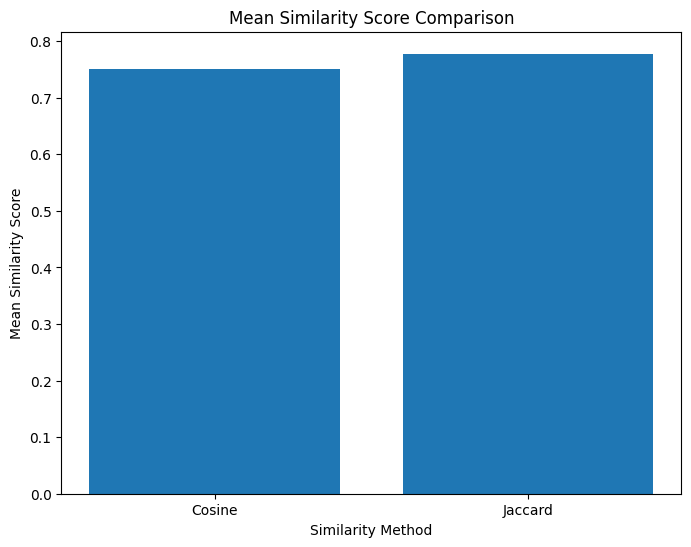

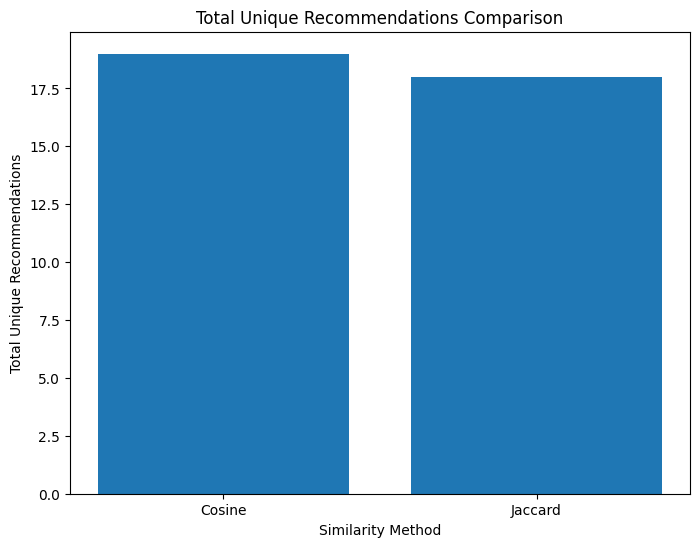

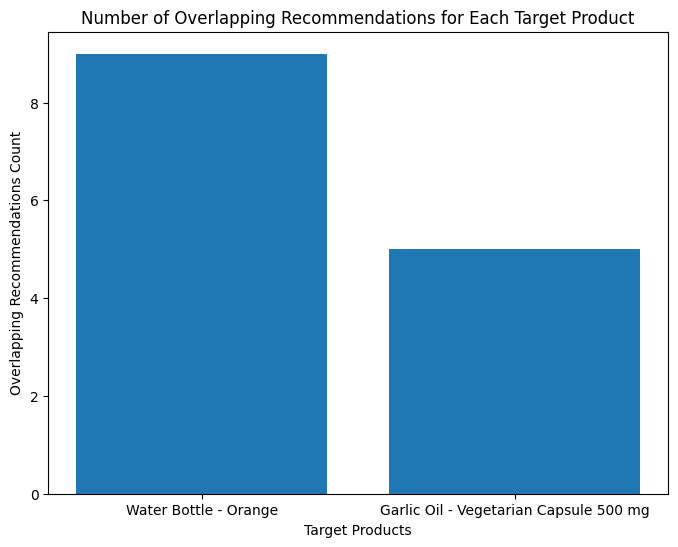

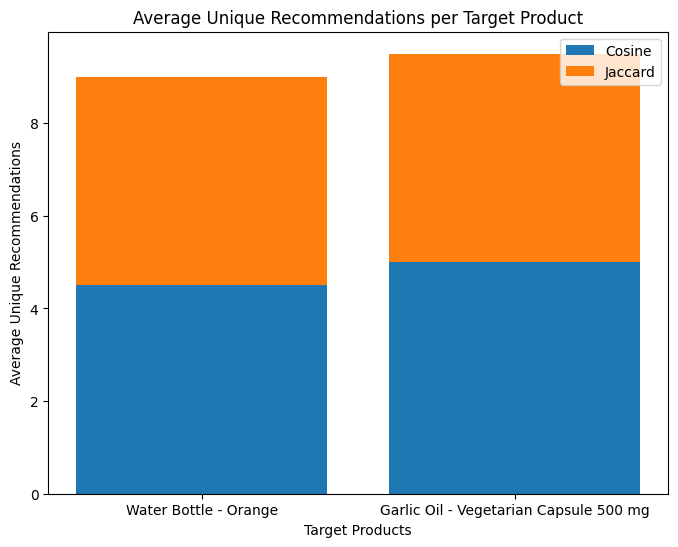

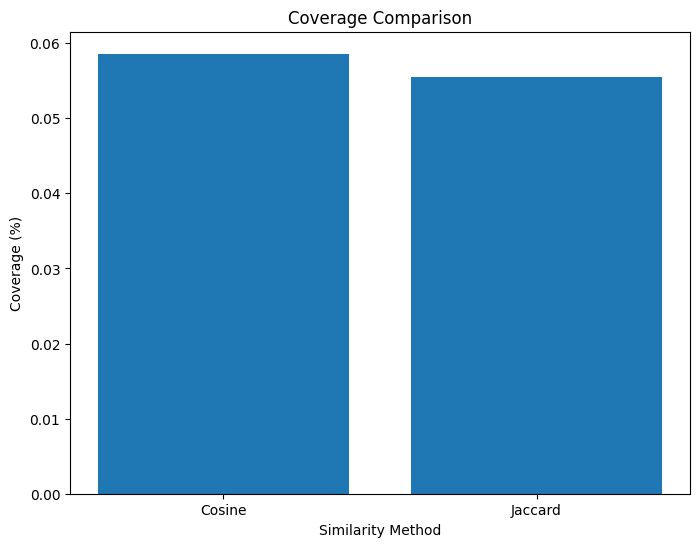

In [ ]:
# Step 2: Evaluate Recommendations and Calculate Metrics
target_products = ['Water Bottle - Orange', 'Garlic Oil - Vegetarian Capsule 500 mg']
cosine_similarity_scores = []
jaccard_similarity_scores = []
unique_recommendations_counts_cosine = []
unique_recommendations_counts_jaccard = []
overlapping_recommendations_counts = []
coverage_cosine = []
coverage_jaccard = []

for product in target_products:
    rec_cosine = get_recommendations_cosine(product)
    rec_jaccard = get_recommendations_jaccard(product, df2)

    # Calculate the similarity scores between the two methods
    cosine_similarity = len(set(rec_cosine).intersection(set(rec_jaccard))) / len(set(rec_cosine))
    jaccard_similarity = len(set(rec_cosine).intersection(set(rec_jaccard))) / len(set(rec_jaccard))

    cosine_similarity_scores.append(cosine_similarity)
    jaccard_similarity_scores.append(jaccard_similarity)

    # Calculate the unique recommendations count for each method
    unique_recommendations_count_cosine = len(set(rec_cosine))
    unique_recommendations_count_jaccard = len(set(rec_jaccard))
    unique_recommendations_counts_cosine.append(unique_recommendations_count_cosine)
    unique_recommendations_counts_jaccard.append(unique_recommendations_count_jaccard)

    # Calculate the overlapping recommendations count
    overlapping_recommendations_count = len(set(rec_cosine).intersection(set(rec_jaccard)))
    overlapping_recommendations_counts.append(overlapping_recommendations_count)

    # Calculate coverage for each method
    total_products = set(df['product'])
    coverage_cosine.append(len(set(rec_cosine)) / len(total_products) * 100)
    coverage_jaccard.append(len(set(rec_jaccard)) / len(total_products) * 100)

# Step 3: Visualize the comparison
# Bar chart for mean similarity scores
plt.figure(figsize=(8, 6))
plt.bar(['Cosine', 'Jaccard'], [sum(cosine_similarity_scores) / len(cosine_similarity_scores),
                                sum(jaccard_similarity_scores) / len(jaccard_similarity_scores)])
plt.xlabel('Similarity Method')
plt.ylabel('Mean Similarity Score')
plt.title('Mean Similarity Score Comparison')
plt.show()

# Bar chart for unique recommendations count
plt.figure(figsize=(8, 6))
plt.bar(['Cosine', 'Jaccard'], [sum(unique_recommendations_counts_cosine),
                                sum(unique_recommendations_counts_jaccard)])
plt.xlabel('Similarity Method')
plt.ylabel('Total Unique Recommendations')
plt.title('Total Unique Recommendations Comparison')
plt.show()

# Bar chart for overlapping recommendations count
plt.figure(figsize=(8, 6))
plt.bar(target_products, overlapping_recommendations_counts)
plt.xlabel('Target Products')
plt.ylabel('Overlapping Recommendations Count')
plt.title('Number of Overlapping Recommendations for Each Target Product')
plt.show()

# Bar chart for unique recommendations per target product
plt.figure(figsize=(8, 6))
plt.bar(target_products, [count / len(target_products) for count in unique_recommendations_counts_cosine], label='Cosine')
plt.bar(target_products, [count / len(target_products) for count in unique_recommendations_counts_jaccard], label='Jaccard', bottom=[count / len(target_products) for count in unique_recommendations_counts_cosine])
plt.xlabel('Target Products')
plt.ylabel('Average Unique Recommendations')
plt.title('Average Unique Recommendations per Target Product')
plt.legend()
plt.show()

# Bar chart for coverage
plt.figure(figsize=(8, 6))
plt.bar(['Cosine', 'Jaccard'], [sum(coverage_cosine) / len(coverage_cosine),
                                sum(coverage_jaccard) / len(coverage_jaccard)])
plt.xlabel('Similarity Method')
plt.ylabel('Coverage (%)')
plt.title('Coverage Comparison')
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



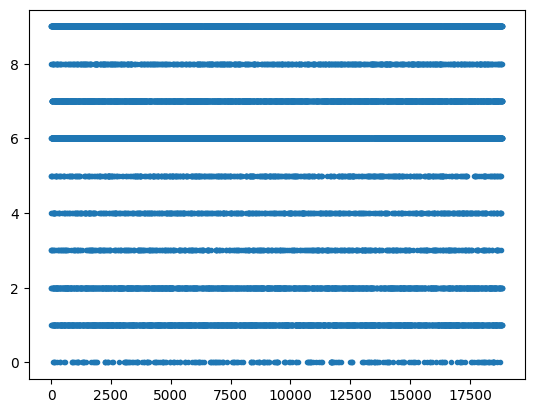

In [ ]:
# Fitting K-Means to the dataset

X=X1
x5=X1
kmeans = KMeans(n_clusters = 10, init = 'k-means++')
y_kmeans = kmeans.fit_predict(X)

plt.plot(y_kmeans, ".")
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Target Product:
Water Bottle - Orange
Top 10 closest products to the target product by K-means:
Rectangular Plastic Container - With Lid, Multicolour
Jar - With Lid, Yellow
Premium Round Plastic Container With Lid - Yellow
Premium Rectangular Plastic Container With Lid - Multicolour
Premium Rectangular Plastic Container With Lid - Multicolour
Premium Plastic Jar With Lid - Green
Premium Plastic Jar With Lid - Green
Plastic Round Glass With Lid - Yellow
Plastic Container - Square, Pink
Plastic Round Glass With Lid - Pink
Average Intra-cluster Similarity: 0.012682843157379295
Average Inter-cluster Dissimilarity: 0.42539635596941566


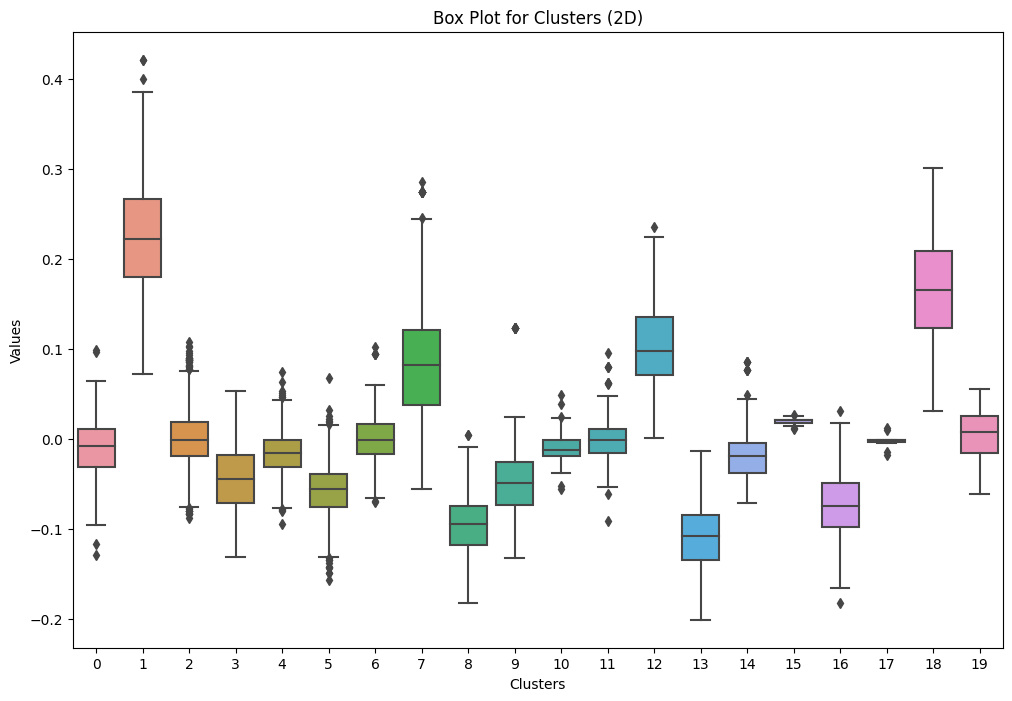

Average Silhouette Score: 0.012682843157379295


In [ ]:

import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.metrics import pairwise_distances



# Step 1: Preprocess the description column
df3 = df2.head(10000)
preprocessed_descriptions = df3['description'].apply(clean_text)

# Step 2: Create numerical representation using TF-IDF
vectorizer1 = TfidfVectorizer()
numerical_representations = vectorizer1.fit_transform([' '.join(description) for description in preprocessed_descriptions])

# Step 3: Apply K-Means Clustering
n_clusters = 20
clustering1 = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels1 = clustering1.fit_predict(numerical_representations)

target_product_index = 1
# Assume target_product_index is the index of the target product


print("Target Product:")
print(df3.iloc[target_product_index]['product'])  # Highlighting the target product

# Calculate distances between the target product and all other products in the same cluster
distances_to_target = pairwise_distances(numerical_representations[target_product_index].reshape(1, -1), numerical_representations, metric='euclidean').flatten()

# Sort the distances in ascending order (closer products will have lower distances)
sorted_indices = np.argsort(distances_to_target)

# Get the top 10 closest product indices (excluding the target product itself)
top_10_indices = sorted_indices[1:11]
top_2 = []

# Print the top 10 closest products
print("Top 10 closest products to the target product by K-means:")
for index in top_10_indices:
    print(df3.iloc[index]['product'])  # Highlighting the recommendations
    top_2.append(df3.iloc[index]['product'])

### intra clust and inter clust
# Calculate silhouette score for each sample
silhouette_avg = silhouette_score(numerical_representations, cluster_labels1)

# Calculate average intra-cluster similarity
silhouette_per_sample = silhouette_samples(numerical_representations, cluster_labels1)
avg_intra_cluster_similarity = np.mean(silhouette_per_sample)
print("Average Intra-cluster Similarity:", avg_intra_cluster_similarity)

# Calculate inter-cluster dissimilarity
inter_cluster_distances = pairwise_distances(clustering1.cluster_centers_)
avg_inter_cluster_dissimilarity = np.mean(inter_cluster_distances)
print("Average Inter-cluster Dissimilarity:", avg_inter_cluster_dissimilarity)


###end
# Step 4: Use PCA for dimensionality reduction to 2 dimensions
pca = PCA(n_components=2)
reduced_representation = pca.fit_transform(numerical_representations.toarray())

# Create a DataFrame to store the cluster data
data = pd.DataFrame({'X': reduced_representation[:, 0], 'Y': reduced_representation[:, 1], 'Cluster': cluster_labels1})

# Step 5: Create a box plot to visualize the spread of data points for each cluster
fig, ax = plt.subplots(figsize=(12, 8))

# Use Seaborn's boxplot to create the box plot
import seaborn as sns
sns.boxplot(data=data, x='Cluster', y='Y')

ax.set_xlabel('Clusters')
ax.set_ylabel('Values')
ax.set_title('Box Plot for Clusters (2D)')

plt.show()
print("Average Silhouette Score:", silhouette_avg)


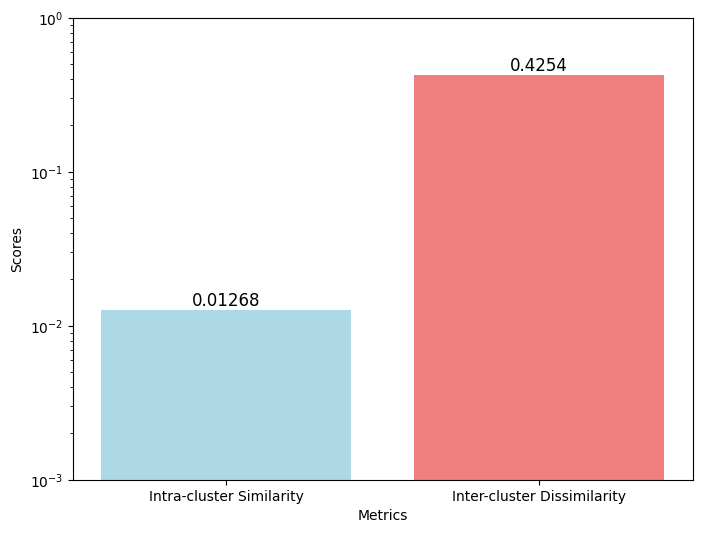

In [ ]:
import matplotlib.pyplot as plt

# Average similarity scores
average_intra_cluster_similarity = 0.012682843157379295  # Replace with your calculated value
average_inter_cluster_dissimilarity = 0.42539635596941566  # Replace with your calculated value

# Create bar chart
labels = ['Intra-cluster Similarity', 'Inter-cluster Dissimilarity']
scores = [average_intra_cluster_similarity, average_inter_cluster_dissimilarity]

plt.figure(figsize=(8, 6))
bars = plt.bar(labels, scores, color=['lightblue', 'lightcoral'])
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.yscale('log')  # Use logarithmic scale for better visualization
plt.ylim(0.001, 1)  # Adjust the y-axis range

# Add annotations to the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 5), ha='center', va='bottom', fontsize=12)

plt.show()


In [ ]:
def print_cluster(i):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind]),
    print

In [ ]:
 # # Optimal clusters is

true_k = 20

model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(X1)

print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()
for i in range(true_k):
      print_cluster(i)





Top terms per cluster:
Cluster 0:
 address
 limited
 bangalore
 customerservice
 email
 feedback
 1860
 phone
 123
 queries
Cluster 1:
 tricks
 tips
 blog
 https
 beauty
 bigbasket
 visit
 visitã
 skin
 fragrance
Cluster 2:
 steel
 stainless
 quality
 durable
 cooking
 kitchen
 high
 cookware
 easy
 cooker
Cluster 3:
 baby
 diaper
 pants
 skin
 soft
 pampers
 diapers
 delicate
 wetness
 comfortable
Cluster 4:
 easy
 cleaning
 use
 home
 quality
 plastic
 water
 bottle
 used
 clean
Cluster 5:
 chocolate
 coffee
 milk
 dark
 delicious
 cocoa
 taste
 chocolates
 rich
 choco
Cluster 6:
 glass
 food
 resistant
 safe
 glasses
 dishwasher
 quality
 grade
 bowls
 serving
Cluster 7:
 oil
 essential
 olive
 skin
 coconut
 oils
 organic
 natural
 pressed
 cold
Cluster 8:
 skin
 face
 oil
 natural
 wash
 helps
 cream
 glow
 soap
 soft
Cluster 9:
 tea
 green
 cup
 leaves
 coffee
 cups
 flavour
 come
 tulsi
 teas
Cluster 10:
 rice
 sauce
 delicious
 basmati
 recipes
 flavors
 www
 collections
 com
 

In [ ]:
def show_recommendations(product):
    #print("Cluster ID:")
    Y = vectorizer.transform([product])
    prediction = model.predict(Y)
    #print(prediction)
    print_cluster(prediction[0])

In [ ]:
show_recommendations("steel")

Cluster 2:
 steel
 stainless
 quality
 durable
 cooking
 kitchen
 high
 cookware
 easy
 cooker


In [ ]:
#FIND THE ROW AND SHOW THE PRODUCT NAME FROM THE CLUSTER WE GOT!!!
#NEED TO FIND A METHOD FOR THIS!!!!

df_extr = df[df['description'].str.contains('steel')]
print(df_extr["product"].head())

index
25                                        Veggie Cutter
26    Insulated Hot Fresh Casserole For Roti/Chapati...
44      Storage/Lunch Steel Container with PP Lid - Red
61            Atta Chalan - Stainless Steel, Size- No.8
95    Stainless Steel Storage Lunch Container - Flat...
Name: product, dtype: object


In [ ]:
import pandas as pd
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import AgglomerativeClustering

# Preprocessing function
def clean_text(text):
    # Tokenize the text
    tokens = re.split(r"\W+", text)

    # Lowercase the tokens
    tokens = [token.lower() for token in tokens]

    # Remove stopwords
    stopwords2 = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stopwords2]

    # Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Remove duplicates
    tokens = list(set(tokens))

    return tokens

# Step 1: Preprocess the description column
df3 = df2.head(1000)
preprocessed_descriptions = df3['description'].apply(clean_text)
print(preprocessed_descriptions)


0      [, blog, digestion, immunity, level, proper, h...
1      [, factor, attractive, microwave, wide, look, ...
2      [, foot, law, sister, beautiful, balanced, ind...
3      [, highly, long, attractive, food, style, solu...
4      [, blog, f, almond, vitamin, creme, gracious, ...
                             ...                        
995    [, room, every, dream, aroma, best, lavender, ...
996    [fogging, , contaminated, coverage, clip, flui...
997    [, premium, mosquito, including, deet, sirona,...
998    [, recipe, edgy, versatile, zingy, ever, lates...
999    [, long, attractive, exclusive, freezer, proof...
Name: description, Length: 1000, dtype: object


In [ ]:

#Step 2: Create numerical representation using TF-IDF
vectorizer = TfidfVectorizer()
numerical_representations1 = vectorizer.fit_transform([' '.join(description) for description in preprocessed_descriptions])

# Step 3: Apply Hierarchical Clustering
clustering = AgglomerativeClustering(n_clusters=50)
cluster_labels = clustering.fit_predict(numerical_representations1.toarray())

# Step 4: Select a target product index
target_product_index = 1 # Choose the index of the target product

print("Target Product:")
print(df3.iloc[target_product_index]['product'])
# Step 5: Find recommendations based on hierarchical clustering
target_cluster_label = cluster_labels[target_product_index]
similar_products = df3.loc[cluster_labels == target_cluster_label, 'product']

recommendations = similar_products.values.tolist()
rec_2=[]
print("Top closest products to the target product by Agglomerative Clustering:")
for rec in range(8):
  print(recommendations[rec])
  if rec <=2:
    rec_2.append(recommendations[rec])

import numpy as np

# Step 4: Calculate Average Intra-cluster Similarity and Average Inter-cluster Dissimilarity
def calculate_avg_intra_inter(X, cluster_labels):
    # Calculate silhouette scores for each sample
    silhouette_per_sample = silhouette_samples(X, cluster_labels)

    # Calculate average intra-cluster similarity
    avg_intra_cluster_similarity = np.mean(silhouette_per_sample)

    # Calculate average inter-cluster dissimilarity
    avg_inter_cluster_dissimilarity = np.mean(silhouette_per_sample.max() - silhouette_per_sample)

    return avg_intra_cluster_similarity, avg_inter_cluster_dissimilarity

# Calculate Average Intra-cluster Similarity and Average Inter-cluster Dissimilarity for Agglomerative Clustering
avg_intra_sim_agglomerative, avg_inter_dissim_agglomerative = calculate_avg_intra_inter(numerical_representations1, cluster_labels)

# Print the results
print("Average Intra-cluster Similarity for Agglomerative Clustering:", avg_intra_sim_agglomerative)
print("Average Inter-cluster Dissimilarity for Agglomerative Clustering:", avg_inter_dissim_agglomerative)


Target Product:
Water Bottle - Orange
Top closest products to the target product by Agglomerative Clustering:
Water Bottle - Orange
Premium Square Plastic Container - Green
Solitaire Storage Transparent Pet Container Set - Green Lid
Premium Flat Square Plastic Container Set - Blue
Airtight Plastic Turn & Lock Jar With Spoon - Printed, Assorted Colour
Magic Seal Square Storage Plastic Container - Royal Blue
Stylo Storage Plastic Container - Printed, Blue
Plastic Container Set - Round, Pink
Average Intra-cluster Similarity for Agglomerative Clustering: 0.016675239746350393
Average Inter-cluster Dissimilarity for Agglomerative Clustering: 0.9833247602536496


In [ ]:
# Get cosine recommendations
cosine_rec = get_recommendations_2('Water Bottle - Orange', cosine_sim2).values

# Calculate the number of recommendations to take from each method
num_cosine_rec = int(0.5 * 10)  # 80% from cosine
num_kmeans_rec = 10 - num_cosine_rec  # 20% from K-means

top_2=top_2[0:2]

# Merge the recommendations
merged_rec = np.concatenate((cosine_rec[:num_cosine_rec],rec_2,top_2))

# Display the merged recommendations
print("Merged Recommendations (50% Cosine, 30% agglo, 20%kmeans):")
for i, rec in enumerate(merged_rec):
    if i<=4:

      print(f"{i+1}. {rec} - cosine")
    elif i>4 and i<=7 :

      print(f"{i+1}. {rec} - agglo")
    else:
      print(f"{i+1}. {rec} - kmeans")





Merged Recommendations (50% Cosine, 30% agglo, 20%kmeans):
1. Glass Water Bottle - Aquaria Organic Purple - cosine
2. Glass Water Bottle With Round Base - Transparent, B1364 - cosine
3. H2O Unbreakable Water Bottle - Pink - cosine
4. Water Bottle H2O Purple - cosine
5. H2O Unbreakable Water Bottle - Green - cosine
6. Water Bottle - Orange - agglo
7. Premium Square Plastic Container - Green - agglo
8. Solitaire Storage Transparent Pet Container Set - Green Lid - agglo
9. Rectangular Plastic Container - With Lid, Multicolour - kmeans
10. Jar - With Lid, Yellow - kmeans


In [ ]:
from sklearn.metrics import silhouette_score


# Step 3: Calculate Recommendations for K-Means and Agglomerative Clustering (You already did this)

# Step 4: Evaluate Clustering Algorithms using Silhouette Score
def evaluate_clustering(X, cluster_labels):
    # Calculate the silhouette score
    silhouette_avg = silhouette_score(X, cluster_labels)

    # Print the silhouette score
    print("Silhouette Score:", silhouette_avg)

    return silhouette_avg

# Evaluate K-Means
silhouette_kmeans = evaluate_clustering(numerical_representations, cluster_labels1)

# Step 2: Create numerical representation using TF-IDF for the entire dataset
vectorizer = TfidfVectorizer(stop_words='english')
X2 = vectorizer.fit_transform([' '.join(description) for description in preprocessed_descriptions])

# Step 3: Apply Hierarchical Clustering on the entire dataset
clustering = AgglomerativeClustering(n_clusters=50)
cluster_labels_agglomerative = clustering.fit_predict(X2.toarray())

# Evaluate Agglomerative Clustering
silhouette_agglomerative = evaluate_clustering(X2, cluster_labels_agglomerative)





Silhouette Score: 0.012682843157379295
Silhouette Score: 0.04401976292442692


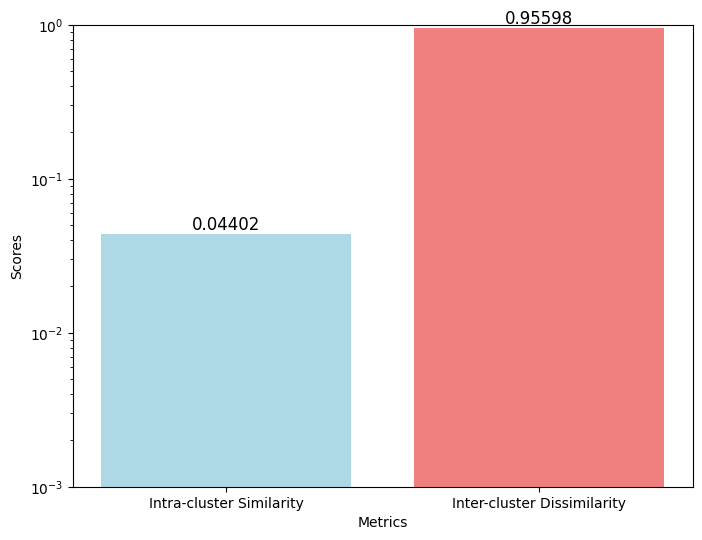

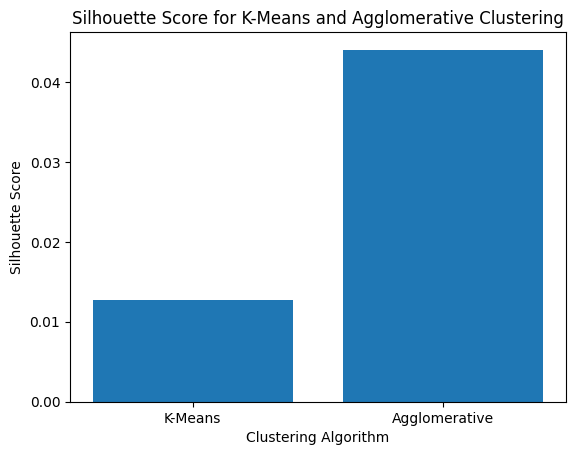

In [ ]:



# Average similarity scores
average_intra_cluster_similarity = 0.04401976292442692  # Replace with your calculated value
average_inter_cluster_dissimilarity = 0.9559802370755732  # Replace with your calculated value

# Create bar chart
labels = ['Intra-cluster Similarity', 'Inter-cluster Dissimilarity']
scores = [average_intra_cluster_similarity, average_inter_cluster_dissimilarity]

plt.figure(figsize=(8, 6))
bars = plt.bar(labels, scores, color=['lightblue', 'lightcoral'])
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.yscale('log')  # Use logarithmic scale for better visualization
plt.ylim(0.001, 1)  # Adjust the y-axis range

# Add annotations to the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 5), ha='center', va='bottom', fontsize=12)

plt.show()

labels = ['K-Means', 'Agglomerative']
silhouette_scores = [silhouette_kmeans, silhouette_agglomerative]

plt.bar(labels, silhouette_scores)
plt.xlabel('Clustering Algorithm')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for K-Means and Agglomerative Clustering')
plt.show()